In [1]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch

NET_PARAMS = {
    'hidden_shape': [50, 75],
    'learning_rate': 0.03,
    'batch_size': 64,
    'transfer': 'sigmoid',
    'patience': 15
}

class Net(nn.Module):
    def __init__(self, inp_shape, hidden_shape, out_shape, transfer=NET_PARAMS['transfer']):
        super(Net, self).__init__()
        self.inp_shape = inp_shape
        self.hidden_shape = hidden_shape
        self.out_shape = out_shape

        self.transfer = torch.sigmoid if transfer == 'sigmoid' else torch.tanh
        self.input_layer = nn.Linear(self.inp_shape, self.hidden_shape[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(self.hidden_shape[hi-1], self.hidden_shape[hi]) for hi in range(1, len(self.hidden_shape))])
        self.output_layer = nn.Linear(self.hidden_shape[-1], self.out_shape)

        self.train()

    def forward(self, x):
        x = self.transfer(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = self.transfer(layer(x))
        
        return self.output_layer(x)
    
    def new_m(self, m):
        self.output_layer = nn.Linear(self.hidden_shape[-1], m)

class Model:

    def __init__(self):
        self.text2vec = SentenceTransformer('fav-kky/FERNET-C5')

        # Net
        self.net = None

        # Labels
        self.target2label = None
        
        # Optimizer
        self.optimizer = None
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def encode_input(self, text):
        return self.text2vec.encode(text)
    
    def decode_output(self, vec):
        return self.target2label[torch.argmax(vec).item()]

    def init_net(self, dataset, print_summary=True):
        self.net = Net(dataset['train'].n, NET_PARAMS['hidden_shape'], dataset['train'].m)
        self.target2label = dataset['train'].target2label
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=NET_PARAMS['learning_rate'])
        
        if print_summary:
            summary(self.net, (1, dataset['train'].n))

    def reinit_net(self, dataset, keep_weights=True, print_summary=True):
        self.net.new_m(dataset['train'].m)
        self.target2label = dataset['train'].target2label
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=NET_PARAMS['learning_rate'])
        
        if print_summary:
            summary(self.net, (1, dataset['train'].n))

    def fit(self, trainloader, devloader=None, epochs=50, verbose=True, save=True):
        train_loss_list = []
        dev_loss_list = []

        for epoch in range(1, epochs+1):

            if epoch % 500 == 0:
                for g in self.optimizer.param_groups:
                    g['lr'] *= 0.75
                    print(f'Epoch {epoch}: Learning rate changed to {g["lr"]}')
            
            # Set model to train configuration
            self.net.train()
            epoch_train_loss_list = []
            for x, y_true, _, _ in trainloader:
                # Clear gradient
                self.optimizer.zero_grad()

                # Make a prediction
                y_pred = self.net(x)

                # Calculate loss
                loss = self.criterion(y_pred, y_true)

                # Calculate gradients of parameters
                loss.backward()

                # Update parameters
                self.optimizer.step()

                epoch_train_loss_list.append(loss.data)

            # Set model to eval configuration
            self.net.eval()
            epoch_dev_loss_list = []
            for x, y_true, _, _ in devloader:
                
                y_pred = self.net(x)

                # Calculate loss
                loss = self.criterion(y_pred, y_true)

                epoch_dev_loss_list.append(loss.data)
            
            mean_train_loss = np.mean([l.item() for l in epoch_train_loss_list])
            mean_dev_loss = np.mean([l.item() for l in epoch_dev_loss_list])
            
            train_loss_list.append(mean_train_loss)
            dev_loss_list.append(mean_dev_loss)
            
            if verbose > 0 and epoch % 50 == 0:
                print(f'epoch {epoch}, train loss {mean_train_loss}, dev loss {mean_dev_loss}')

            if len(dev_loss_list) > NET_PARAMS['patience'] and all([dl < mean_dev_loss for dl in dev_loss_list[-NET_PARAMS['patience']:-1]]):
                print(f'Early stopping, dev_loss tail: {dev_loss_list[-NET_PARAMS["patience"]:-1]}')
                break


        print(f'Final train loss: {train_loss_list[-1].item()}, dev loss: {dev_loss_list[-1].item()}')

        if save:
            torch.save(self.net.state_dict(), 'model-test')

        return train_loss_list, dev_loss_list

    def predict(self, sample, is_encoded=False):
        self.net.eval()
        
        if is_encoded:
            encoded = sample
        else:
            encoded = torch.from_numpy(self.encode_input(sample))

        out = self.net(encoded)
        return self.decode_output(out)
    
    def evaluate(self, testloader):
        self.net.eval()
        loss_list = []
        n_correct = 0
        n_fail = 0
        for x, y_true, _, _ in testloader:
            
            y_pred = self.net(x)
            loss_list.append(self.criterion(y_pred, y_true).data)
            
            if torch.argmax(y_pred).item() == y_true[0].item():
                n_correct += 1
            else:
                n_fail += 1
        
        acc = n_correct / (n_correct + n_fail)
        loss = np.mean([l.item() for l in loss_list])
        print(f'Loss: {loss}, Acc: {acc}')
        
        return loss, acc
    
model = Model()

/Users/kitt/miniconda3/envs/net/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /Users/kitt/.cache/torch/sentence_transformers/fav-kky_FERNET-C5 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are in

In [2]:
class IntentsDataset(Dataset):

    def __init__(self, group, samples, labels, encoder, decoder):
        """
            samples: list: ['sentence 1', 'sentence 2', ... 'sentence n']
            labels: list: ['label 1', 'label 2', ... 'label n']
            encoder: def for encoding input (in: <string> sentence, out: <np.ndarray> vec)
            decoder: def for decoding output (in: <np.ndarray> vec, <string[]> labels, out: <string> label)
        """

        self.group = group
        self.samples = samples
        self.labels = labels
        self.encoder = encoder
        self.decoder = decoder

        self.samples_encoded = np.array([self.encoder(sample) for sample in self.samples])
        self.sorted_labels = sorted(list(set(self.labels)))
        self.target2label = {target:label for target, label in enumerate(self.sorted_labels)}
        self.label2target = [self.sorted_labels.index(label) for label in self.labels]

        self.x = torch.from_numpy(self.samples_encoded.reshape(-1, self.samples_encoded.shape[1]).astype('float32'))
        self.y = torch.tensor(self.label2target)
        self.y_one_hot = F.one_hot(self.y)
        
        self.p = self.x.shape[0]
        self.n = len(self.x[0])
        self.m = len(self.sorted_labels)

        print(f'Dataset {self.group}: n = {self.n}, m = {self.m}, p = {self.p}')
        print(f'Labels: {self.target2label}')

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.samples[index], self.labels[index]

    def __len__(self):
        return self.p
    
    def label(self, one_hot):
        return self.decoder(one_hot, self.labels)

In [3]:
samples = {'train': [], 'dev': [], 'test': []}
labels = {'train': [], 'dev': [], 'test': []}
dataset = {}

LIM = {'train': 2500, 'dev': 500, 'test': 750}

for group in ('train', 'dev', 'test'):
    with open(f'data/{group}-cs.tsv', 'r') as fr:
        for line in fr.readlines()[:LIM[group]]:
            sample, label = line.strip().split('\t')
            samples[group].append(sample)
            labels[group].append(label)

    print(f'Loaded {len(samples[group])} {group} samples, creating dataset...')
    dataset[group] = IntentsDataset(
        group=group,
        samples=samples[group],
        labels=labels[group],
        encoder=model.encode_input,
        decoder=model.decode_output
    )
    
trainloader = DataLoader(dataset=dataset['train'], batch_size=NET_PARAMS['batch_size'], shuffle=True)
devloader = DataLoader(dataset=dataset['dev'], batch_size=256, shuffle=True)
testloader = DataLoader(dataset=dataset['test'], batch_size=1, shuffle=True)

model.init_net(dataset=dataset)

Loaded 2500 train samples, creating dataset...
Dataset train: n = 768, m = 25, p = 2500
Labels: {0: 'application_status', 1: 'change_language', 2: 'change_user_name', 3: 'definition', 4: 'find_phone', 5: 'flight_status', 6: 'flip_coin', 7: 'fun_fact', 8: 'improve_credit_score', 9: 'insurance_change', 10: 'maybe', 11: 'meaning_of_life', 12: 'oil_change_how', 13: 'payday', 14: 'pto_request', 15: 'replacement_card_duration', 16: 'restaurant_reservation', 17: 'shopping_list_update', 18: 'time', 19: 'timer', 20: 'transfer', 21: 'translate', 22: 'travel_alert', 23: 'what_can_i_ask_you', 24: 'where_are_you_from'}
Loaded 500 dev samples, creating dataset...
Dataset dev: n = 768, m = 25, p = 500
Labels: {0: 'application_status', 1: 'change_language', 2: 'change_user_name', 3: 'definition', 4: 'find_phone', 5: 'flight_status', 6: 'flip_coin', 7: 'fun_fact', 8: 'improve_credit_score', 9: 'insurance_change', 10: 'maybe', 11: 'meaning_of_life', 12: 'oil_change_how', 13: 'payday', 14: 'pto_request',

In [6]:
model.fit(trainloader, devloader, epochs=2000, verbose=True)
model.evaluate(testloader)

Early stopping, dev_loss tail: [0.2576027438044548, 0.25586526840925217, 0.25826171040534973, 0.25628622621297836, 0.2579463943839073, 0.257193461060524, 0.25787200778722763, 0.2554153949022293, 0.25691740959882736, 0.25600025802850723, 0.25364550203084946, 0.2544441893696785, 0.25601934641599655, 0.25734076648950577]
Final train loss: 0.05671344064176083, dev loss: 0.26096343249082565
Loss: 0.30482024207587044, Acc: 0.924


(0.30482024207587044, 0.924)

In [ ]:
# Test it

while True:
    inp = input('\n>>')
    if inp == 'stop':
        break

    print(f'>> {model.predict(inp)}')
    print(model.net(torch.from_numpy(model.encode_input(inp))))

In [7]:
# Fine-tune

samples_finetuning = {'train': [], 'dev': [], 'test': []}
labels_finetuning = {'train': [], 'dev': [], 'test': []}
dataset_finetuning = {}

LIM1 = {'train': 2500, 'dev': 500, 'test': 750}
LIM2 = {'train': 500, 'dev': 100, 'test': 150}

for group in ('train', 'dev', 'test'):
    with open(f'data/{group}-cs.tsv', 'r') as fr:
        for line in fr.readlines()[LIM1[group]:LIM1[group]+LIM2[group]]:
            sample, label = line.strip().split('\t')
            samples_finetuning[group].append(sample)
            labels_finetuning[group].append(label)

    print(f'Loaded {len(samples_finetuning[group])} {group} samples, creating dataset...')
    dataset_finetuning[group] = IntentsDataset(
        group=group,
        samples=samples_finetuning[group],
        labels=labels_finetuning[group],
        encoder=model.encode_input,
        decoder=model.decode_output
    )
    
trainloader_finetuning = DataLoader(dataset=dataset_finetuning['train'], batch_size=NET_PARAMS['batch_size'], shuffle=True)
devloader_finetuning = DataLoader(dataset=dataset_finetuning['dev'], batch_size=256, shuffle=True)
testloader_finetuning = DataLoader(dataset=dataset_finetuning['test'], batch_size=1, shuffle=True)

Loaded 2500 train samples, creating dataset...
Dataset train: n = 768, m = 5, p = 500
Labels: {0: 'balance', 1: 'confirm_reservation', 2: 'freeze_account', 3: 'rollover_401k', 4: 'who_made_you'}
Loaded 500 dev samples, creating dataset...
Dataset dev: n = 768, m = 5, p = 100
Labels: {0: 'balance', 1: 'confirm_reservation', 2: 'freeze_account', 3: 'rollover_401k', 4: 'who_made_you'}
Loaded 750 test samples, creating dataset...
Dataset test: n = 768, m = 5, p = 150
Labels: {0: 'balance', 1: 'confirm_reservation', 2: 'freeze_account', 3: 'rollover_401k', 4: 'who_made_you'}


In [9]:
# Just replacing the last layer (depending on number of classes), otherwise keep trained weights (cool initialization)
model.reinit_net(dataset=dataset_finetuning, keep_weights=True)

# A new clean one for comparison
model2 = Model()
model2.init_net(dataset=dataset_finetuning)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]          38,450
            Linear-2                [-1, 1, 75]           3,825
            Linear-3                 [-1, 1, 5]             380
Total params: 42,655
Trainable params: 42,655
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


Some weights of the model checkpoint at /Users/kitt/.cache/torch/sentence_transformers/fav-kky_FERNET-C5 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]          38,450
            Linear-2                [-1, 1, 75]           3,825
            Linear-3                 [-1, 1, 5]             380
Total params: 42,655
Trainable params: 42,655
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [10]:
# finetuning
train_loss_ft, dev_loss_ft = model.fit(trainloader_finetuning, devloader_finetuning, epochs=2000, verbose=True)
model.evaluate(testloader_finetuning)

# from scratch
train_loss_scratch, dev_loss_scratch = model2.fit(trainloader_finetuning, devloader_finetuning, epochs=2000, verbose=True)
model2.evaluate(testloader_finetuning)

epoch 50, train loss 0.22241861559450626, dev loss 0.23995569348335266
epoch 100, train loss 0.08063720818608999, dev loss 0.11053916811943054
epoch 150, train loss 0.041384900687262416, dev loss 0.07387806475162506
epoch 200, train loss 0.025776632828637958, dev loss 0.0577172189950943
epoch 250, train loss 0.018183590611442924, dev loss 0.04846268519759178
epoch 300, train loss 0.013555612764321268, dev loss 0.042365189641714096
epoch 350, train loss 0.010889378434512764, dev loss 0.03825026750564575
epoch 400, train loss 0.00896328070666641, dev loss 0.03508283197879791
epoch 450, train loss 0.007517754449509084, dev loss 0.03263871371746063
Epoch 500: Learning rate changed to 0.0225
epoch 500, train loss 0.006497425143606961, dev loss 0.03066050074994564
epoch 550, train loss 0.005895041336771101, dev loss 0.029417552053928375
epoch 600, train loss 0.005353891116101295, dev loss 0.028338424861431122
epoch 650, train loss 0.004928465816192329, dev loss 0.027391590178012848
epoch 700

(0.04942478734922285, 0.98)

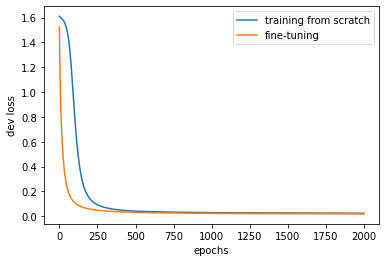

In [13]:
from matplotlib import pyplot as plt

plt.plot(dev_loss_scratch[:500], label='training from scratch')
plt.plot(dev_loss_ft[:500], label='fine-tuning')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('dev loss')
plt.show()